# Section 2: Sentiment Analysis on SnappFood dataset

## Sentiment Analysis using CNN

In this section, we want to use CNN for sentiment analysis. Our dataset is the SnappFood dataset that is preprocessed in the previous notebook for sentiment analysis using LSTM. Now we use SnappFood preprocessed dataset

In [1]:
# plot
import matplotlib.pyplot as plt

import pandas as pd
import string
import re
import numpy as np
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Prepare Dataset for Neural Network

In [ ]:
#load the preprocessing dataframe
snapp_train = pd.read_pickle(r'/content/drive/MyDrive/AI-Internship/SnappFood_FinalEdit/snapp_train')
snapp_valid = pd.read_pickle(r'/content/drive/MyDrive/AI-Internship/SnappFood_FinalEdit/snapp_valid')
snapp_test = pd.read_pickle(r'/content/drive/MyDrive/AI-Internship/SnappFood_FinalEdit/snapp_test')


In [ ]:
print(f'snapp train shape : {snapp_train.shape}')
print(f'snapp valid shape : {snapp_valid.shape}')
print(f'snapp test shape : {snapp_test.shape}')

snapp train shape : (56495, 2)
snapp valid shape : (6286, 2)
snapp test shape : (6979, 2)


Let's take a look at length of texts in dataset.

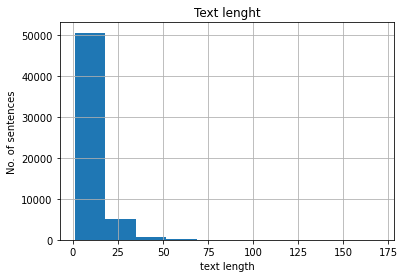

count    56495.000000
mean         8.778494
std          7.490531
min          1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max        170.000000
dtype: float64

In [ ]:
text_len = [len(i.split()) for i in snapp_train.preprocessing_text.values]
pd.Series(text_len).hist()
plt.title('Text lenght')
plt.xlabel('text length')
plt.ylabel('No. of sentences')
plt.show()
pd.Series(text_len).describe()

Let's print one sentences with its words.

In [ ]:
[(i.split()) for i in snapp_train.preprocessing_text.values[:1]]

[['حیف', 'وقت', 'نوشت', 'سرویس', 'دهیتون', 'افتضاح']]

As we see in the above histogram, we have sentences with length one. Because we want to use CNN for our work, and we have different convolution layers with different kernel sizes, we should be upsampling the texts with length, lower than maximum lenght. In the following cell, we want to see how many sentences we have with lengths equals to one.

In [ ]:
len_one = []
for i in snapp_train.preprocessing_text.values:
  if len(i.split())==1: 
    len_one.append(i)

print(len_one)
print(f'we have {len(len_one)} texts with lenghts = 1')

['خوشمزه', 'غذا', 'عالی', 'عالی', 'غذا', 'اسنپ', 'یبار', 'سرد', 'عالی', 'عالی', 'مرسییییی', 'کیفیت', 'اندازه', 'متشکر', 'نظیره', 'کیفیت', 'لوبیپلو', 'سفارش', 'غذا', 'ارسال', 'خوشمزه', 'کیفیت', 'متشکر', 'ممنون', 'فاکتور', 'شور', 'شکلات', 'غذا', 'عالی', 'سپاسگزار', 'ومتنوع', 'بدتر', 'همهچیش', 'ترد', 'عالی', 'ممنون', 'تواضع', 'تاخیر', 'عالی', 'عالی', 'عالیییی', 'عالی', 'نون', 'تند', 'موقع', 'عالی', 'نهایت', 'کیلو', 'راضی', 'تشکر', 'ضعیف', 'عالی', 'راضی', 'عالی', 'شل', 'موقع', 'عالی', 'موقع', 'غذا', 'شیرینی', 'چیزکیک', 'طعم', 'طعم', 'عالی', 'تست', 'موقع', 'دست', 'نون', 'عالی', 'ممنون', 'داغ', 'پول', 'داغ', 'عالی', 'کیفیت', 'سرد', 'منظم', 'توصیه', 'بادقت', 'وبموقع', 'خوشمزه', 'غذا', 'کیفیت', 'قیمت', 'قیمت', 'اومد', 'قربان', 'قناد', 'قارچ', 'راضی', 'مرغ', 'عالی', 'متشکر', 'دلپذیر', 'سرد', 'دوظرف', 'ممنون', 'شیرینی', 'عالی', 'لذیذ', 'تایم', 'حجمشو', 'تحویل', 'کیفیت', 'غذا', 'فرستاده', 'خوشمزه', 'عاااالیه', 'قیمت', 'تاخیر', 'تحویل', 'دیگس', 'تشکر', 'موقع', 'درد', 'مگه', 'خوشمزه', 'طعم', 'عاااا

#### Load the custom dataset using PyTorchText TabularDataset

In [3]:
import torch
import torchtext
from torchtext.legacy import data
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torch.utils.data.dataset import random_split

from sklearn.model_selection import train_test_split
from torchtext.vocab import Vectors
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

#Reproducing same results
SEED = 2019
torch.manual_seed(SEED)

In [4]:
# define pipline for text and label columns
TEXT = data.Field(tokenize='spacy',
                  include_lengths=True, batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

Let's define our column name and preprocessing pipline for that column, with tupless in fileds.

In [5]:
fields = [('label', LABEL), ('preprocessing_text',TEXT)]

In [6]:
train_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/SnappFood_FinalEdit/train.csv'
                                , format='csv', fields=fields, skip_header=True)

valid_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/SnappFood_FinalEdit/valid.csv'
                                , format='csv', fields=fields, skip_header=True)

test_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/SnappFood_FinalEdit/test.csv'
                                , format='csv', fields=fields, skip_header=True)


In [7]:
type(train_data)

torchtext.legacy.data.dataset.TabularDataset

In [8]:
len(train_data)

56495

In [9]:
[(elem.label) for elem in train_data][:2]

['1', '0']

#### Construct Vocabulary

Now, we should construct vocabulary from our text and convert them into integer sequences. The vocabulary contains unique words and assigns an index for each word.

In [10]:
TEXT.build_vocab(train_data, valid_data,min_freq=3 )
LABEL.build_vocab(train_data, valid_data)

In [11]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))
print("Size of TEXT vocabulary:",len(LABEL.vocab))
print(" ")
print('-'*200)

#Commonly used words
print(f'10 commonly used words : {TEXT.vocab.freqs.most_common(10)}')  
print(" ")
print('-'*200)

#Word dictionary
print(f'word dictionary : {TEXT.vocab.stoi}') 

Size of TEXT vocabulary: 6839
Size of TEXT vocabulary: 2
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
10 commonly used words : [('غذا', 16683), ('کیفیت', 13919), ('عالی', 11461), ('سفارش', 11291), ('پیتزا', 8998), ('ممنون', 6085), ('سرد', 6085), ('خوشمزه', 5628), ('طعم', 5254), ('ارسال', 5158)]
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
word dictionary : defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f5f85760c90>>, {'<unk>': 0, '<pad>': 1, 'غذا': 2, 'کیفیت': 3, 'عالی': 4, 'سفارش': 5, 'پیتزا': 6, 'سرد': 7, 'ممنون': 8, 'خوشمزه': 9, 'طعم': 10, 'ارسال': 11, 'مرغ': 12, 'پیک': 13, 'قیمت': 14, 'مزه': 15, 'سیب': 16, 'سس': 17, 'تحویل

Now, we will prepare batches for training the model. We use BucketIterator for this work.

In this problem, we use BucketIterator, because we want to use LSTM (a kind of recurrent neural network), and it accepts inputs with fixed size (because our texts are in different sizes, we should use padding for this work). So using BucketIterator helps us to have little processing for padding.

In [12]:
train_batch_size = 64
valid_batch_size = 128
test_batch_size = 128

In [13]:
# create dataloader
train_loader = data.BucketIterator(train_data, train_batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=True, shuffle=True, sort_within_batch=True)

valid_loader = data.BucketIterator(valid_data, valid_batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=False, shuffle=False, sort_within_batch=True)

test_loader = data.BucketIterator(test_data, test_batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=False, shuffle=False, sort_within_batch=True)


In [14]:
print(f'length of train_dataset is : {len(train_data)} and length of train_loader is : {len(train_loader)}')
print(f'length of valid_dataset is : {len(valid_data)} and length of valid_loader is : {len(valid_loader)}')
print(f'length of test_dataset is : {len(test_data)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 56495 and length of train_loader is : 883
length of valid_dataset is : 6286 and length of valid_loader is : 50
length of test_dataset is : 6979 and length of test_loader is : 55


Let's look at frist batch of train_loader. As we see, BucketIterator takes texts with similar length in one batch.

**It's important to call create_batches() before each epoch**

In [15]:
train_loader.create_batches()
for batch in train_loader.batches:
  print(f'batch size : {len(batch)}')
  print(batch)

  for example in batch:
    print(f'example label : {example.label} | example length : {len(example.preprocessing_text)}')
  break  

batch size : 64
[<torchtext.legacy.data.example.Example object at 0x7fb8e3189ad0>, <torchtext.legacy.data.example.Example object at 0x7fb8e41ffb90>, <torchtext.legacy.data.example.Example object at 0x7fb8e2a584d0>, <torchtext.legacy.data.example.Example object at 0x7fb8e3902290>, <torchtext.legacy.data.example.Example object at 0x7fb8e4cfc4d0>, <torchtext.legacy.data.example.Example object at 0x7fb8e4cf38d0>, <torchtext.legacy.data.example.Example object at 0x7fb8e4e61450>, <torchtext.legacy.data.example.Example object at 0x7fb8e5693350>, <torchtext.legacy.data.example.Example object at 0x7fb8e54732d0>, <torchtext.legacy.data.example.Example object at 0x7fb8e51e3c10>, <torchtext.legacy.data.example.Example object at 0x7fb8e51cbf50>, <torchtext.legacy.data.example.Example object at 0x7fb8e3474d90>, <torchtext.legacy.data.example.Example object at 0x7fb8e4d82cd0>, <torchtext.legacy.data.example.Example object at 0x7fb8e6f66e90>, <torchtext.legacy.data.example.Example object at 0x7fb8e682

In [16]:
example.preprocessing_text

['غذا',
 'عالی',
 'ارسال',
 'مشتری',
 'مدار',
 'پیک',
 'مودب',
 'خدا',
 'کسب',
 'کارتون',
 'برکت']

Let's take a look at one batch of train_loader.

As we see in the following cell, when print text_, we expect to have tensor shape like (batch_size * text_length), but this text have shape like (text_length * batch_size ), So we should inverse shape of text before feed it to our model.(my explain it's true when we don't use batch_first=True in TEXT, if use batch_first we don't need to inverse x.transpose() because it makes it in a wrong shape) (batch_size = 10 in this cell
)

In [ ]:
example = iter(train_loader)
text_, label_= next(example)
print(f'label :{label_}')
print(f'text : {text_[0]}')
print(f'text_length : {text_[1]}')

label :tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 1.])
text : tensor([[   6,  157],
        [   0,    8],
        [   4,    8],
        [  32,  522],
        [ 220,    8],
        [   4, 1141],
        [   3,   25],
        [ 170,    0],
        [ 190,   58],
        [ 740,   96]])
text_length : tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [ ]:
for batchess in train_loader:
  x, y = batchess.preprocessing_text
  x = torch.transpose(x, 0, 1)
  print(f'len batch :{len(batchess)}')
  print(f'text:{x}')
  print(f'text shape : {x.shape}')
  print(f'len text : {len(x)}')
  print(f'text_length : {y}')
  break


len batch :10
text:tensor([[  32, 2375,  488,   15,   22,  204,    4,   33,   25,  134],
        [ 181,    5,   19,  475,    6, 2314,  189,   10,  157,    4],
        [ 113,  393,    7,   39, 3013,  267,  259,  182,    0,  143]])
text shape : torch.Size([3, 10])
len text : 3
text_length : tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


### Building model

helpful links:
https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html

https://galhever.medium.com/sentiment-analysis-with-pytorch-part-3-cnn-model-7bb30712abd7

In this section, we want to build CNN model and use it for sentiment analysis on SnappFood dataset. we should define a class for our modle. we don't need anything, because we define dataloader and anything we need(i.e. vocabulary) before.

In [15]:
class CNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim
               , dropout, pad_idx):
    super(CNN, self).__init__()
    
    # we consider embedding layer as a lookup table that assigns each word a vector
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    
    # we define convolutional layers in ModuleList
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim)) 
                                         for fs in filter_sizes])

    self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)

    self.dropout = nn.Dropout(dropout)
    self.sigmoid = nn.Sigmoid()

  def forward(self, text):
    
    # text = [batch_size, sent length]
    embedded = self.embedding(text)

    # because min len text ==1, we should add 4 to it dimention, because our max kernel size is 5
    # padding
    # embedded = [batch_size, sent length, emb dim]
    embedded = F.pad(embedded, (0,0,2,2), "constant", 0)

    # embedded = [batch_size, sent length + 4, emb dim]
    embedded = embedded.unsqueeze(1)

    # embedded = [batch_size, 1, sent length + 4, emb dim]
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

    # conved_n = [batch_size, n_filters, sent length + 4 -filter_sizes[n] + 1]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

    # pooled_n = [batch_size, n_filters]
    cat = self.dropout(torch.cat(pooled, dim=1))

    # cat = [batch_size, n_filters * len(filter_sizes)]
    dense_output = self.fc(cat)

    # final activation funciton 
    output = self.sigmoid(dense_output)

    return output


Let's define hyperparameters.

In [16]:
vocab_size = len(TEXT.vocab)
embedding_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1
dropout = 0.5
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model_cnn = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, 
                output_dim, dropout, pad_idx)


In [17]:
print(model_cnn)

CNN(
  (embedding): Embedding(6839, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)


Because we set out filter_sizes to 3, 4 and 5, we check bigrams, 3-grams and 5-grams in our model.

Let's define a function for checking the number of parameters in our model.

In [18]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The CNN model has {count_parameters(model_cnn):,} trainable parameters')


The CNN model has 804,501 trainable parameters


### Train and Evaluate the model

Let's initialize optimizer, loss function and learning rate schedular.

In [19]:
num_epoch = 10
learning_rate= 0.01

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 1, gamma=0.4)


n_total_step = len(train_loader)


In [20]:
# Define a funciton to calculate accuracy for binary class classification model
def binary_accuracy(y_pred, y_act):
    #round predictions to the closest integer
    rounded_preds = torch.round(y_pred)
    
    correct = (rounded_preds == y_act).float() # Show which elements are the same with 1
    acc = correct.sum() / len(correct)
    acc = torch.round(acc * 100)
    return acc

Let's define train and evaluate function. (train and evaluate function in this section is different a little with before, because our model in forward takes only text.)

In [21]:
# define a function for training a model
def train(model1, train_loader):
  
  train_epoch_loss = 0
  train_epoch_acc = 0
  
  # train the model
  model1.train()

  loop = tqdm(enumerate(train_loader), total = n_total_step, leave = False)

  for i, batch in loop:
    
    optimizer.zero_grad()

    # retrieve text and number of words
    text, text_lengths = batch.preprocessing_text

    # convert to 1D tensor
    y_pred = model1(text).squeeze()

    loss_train = criterion(y_pred, batch.label)

    acc_train = binary_accuracy(y_pred, batch.label)

    loss_train.backward()

    optimizer.step()

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item()

    loop.set_description(f'Epoch : [{epoch}/{num_epoch}]')
    loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))  
      
  # if you want to monitor your model in tensorboard   
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch)

  return train_loss, train_acc


# define a function for evaluating model
def evaluate(model1, valid_loader):

  # validation
  with torch.no_grad():
    model1.eval()

    val_epoch_loss = 0
    val_epoch_acc = 0

    for batch in valid_loader:

      text, text_length = batch.preprocessing_text

      y_pred_val = model1(text).squeeze()
      loss_valid = criterion(y_pred_val, batch.label)
      acc_valid = binary_accuracy(y_pred_val, batch.label) 

      val_epoch_loss += loss_valid.item()
      val_epoch_acc += acc_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader))
    valid_acc.append(val_epoch_acc/len(valid_loader))  

  return valid_loss, valid_acc


In [22]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('model_SnappFood')

In [38]:
# %reload_ext tensorboard
# %tensorboard --logdir 'model_SnappFood'

In [24]:
!nvidia-smi

Sat Sep  4 04:51:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
from tqdm import tqdm

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

best_valid_loss = float('inf')

for epoch in range(num_epoch):

  train_loss, train_acc = train(model_cnn, train_loader)
  writer.flush() 
  valid_loss, valid_acc = evaluate(model_cnn, valid_loader)  

  if valid_loss[-1] < best_valid_loss:
    best_valid_loss = valid_loss[-1]
    torch.save(model_cnn.state_dict(), '/content/drive/MyDrive/AI-Internship/BestModelCNN_snappfood')

  scheduler.step()

In [26]:
torch.save(model_cnn, '/content/drive/MyDrive/AI-Internship/model3CNN_snappfood') # model1 with 10 epochs

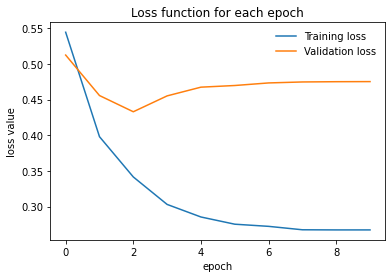

In [27]:
#Training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title("Loss function for each epoch") 
plt.show()

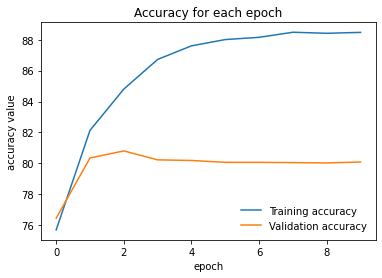

In [28]:
#Training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title("Accuracy for each epoch")
plt.show()

In [29]:
scheduler.state_dict()

{'_get_lr_called_within_step': False,
 '_last_lr': [1.0485760000000006e-06],
 '_step_count': 11,
 'base_lrs': [0.01],
 'gamma': 0.4,
 'last_epoch': 10,
 'step_size': 1,
 'verbose': False}

In [30]:
model_cnn.state_dict

<bound method Module.state_dict of CNN(
  (embedding): Embedding(6839, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)>

In [31]:
print(f'training loss on last epoch : {train_loss[-1]}')
print(f'validation loss on last epoch : {valid_loss[-1]}')
print('-'*20)
print(f'training accuracy on last epoch : {train_acc[-1]}')
print(f'validation accuracy on last epoch : {valid_acc[-1]}')

training loss on last epoch : 0.2673665315992835
validation loss on last epoch : 0.4751617181301117
--------------------
training accuracy on last epoch : 88.47904869762175
validation accuracy on last epoch : 80.08


### Test the model

In [32]:
num_class = 2
classes = ['SAD', 'HAPPY']

In [33]:
def test(model1, test_loader):
  y_pred_test = []
  y_actual_test = []

  model1.eval()
  with torch.no_grad():
    n_true = 0
    n_total = 0
    n_class_correct = [0 for i in range(num_class)]
    n_class_sample = [0 for i in range(num_class)]
  
    for batch in test_loader:

      text, text_length = batch.preprocessing_text

      output = model1(text).squeeze()

      y_predtest = torch.round(output)

      n_true += (y_predtest == batch.label).sum()
      n_total += batch.label.size(0)

      for i in range(len(y_predtest)):
        y_pred_test.append(y_predtest[i])
        y_actual_test.append(batch.label[i].item())

      for i in range(len(y_predtest)):
        lb = int(batch.label[i].item())
        pred = y_predtest[i]
        if pred == lb:
          n_class_correct[lb] += 1
        n_class_sample[lb] += 1   

    print(f'accuracy of network on the {len(test_loader)} texts is : {(n_true/n_total) *100}')
  
    for i in range(len(classes)):
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {classes[i]}: {acc} %')
  
  return y_pred_test, y_actual_test

In [34]:
y_pred_test, y_actual_test = test(model_cnn, test_loader)

accuracy of network on the 55 texts is : 79.66757202148438
Accuracy of SAD: 82.15102974828375 %
Accuracy of HAPPY: 77.17484926787252 %


### Confusion Matrix

In [35]:
from sklearn import metrics 
from sklearn.metrics import classification_report
import seaborn as sns

def confusion_matrix(y_actual_test, y_pred_test):
  
  plt.figure(figsize = (6,5))
  ax= plt.subplot()
  cnf_matrix = metrics.confusion_matrix(y_actual_test, y_pred_test)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix of model'); 
  class_names= [-1, 1]
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()

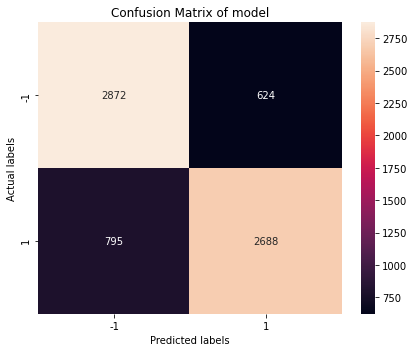

In [36]:
confusion_matrix(y_actual_test, y_pred_test)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      3496
         1.0       0.81      0.77      0.79      3483

    accuracy                           0.80      6979
   macro avg       0.80      0.80      0.80      6979
weighted avg       0.80      0.80      0.80      6979

